# Project Notebook V: Supervised Learning with Sagemaker XGBoost with Hyperparameter Tuning

David Chen

In [1]:
!pip install sagemaker==1.72.0

In [2]:
import pandas as pd 
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer
import boto3

In [3]:
## My custom helper functions
from helpers import *

## Step 1. Sagemaker Resources & Processed+FeatureSelected Data Saved in S3

In [4]:
sagemaker_session = sagemaker.Session()
sagemaker_session

In [5]:
role = sagemaker.get_execution_role()
role

'arn:aws:iam::644307290749:role/service-role/AmazonSageMaker-ExecutionRole-20210527T073969'

In [6]:
bucket = sagemaker_session.default_bucket()
bucket

'sagemaker-us-west-1-644307290749'

In [7]:
## Load processed, L1-selected features:
genes = pd.read_csv(get_s3_uri("assets/processed_data/genes_l1_selected.csv", bucket), index_col=0)
genes.shape

(999, 33)

In [8]:
## Load processed patient annotations (with defined class label):
clinical = pd.read_csv(get_s3_uri("assets/processed_data/clinical.csv", bucket))
clinical.index = clinical['Sample ID'].values
clinical.shape

(999, 15)

In [9]:
## Check to see if patient IDs in the 2 DataFrames match
assert all(genes.index == clinical.index)

## Step 2. Train-val-test split & save for Sagemaker XGBoost

Here, I will split the data into the following sets as CSV files without headers or index (required format for Sagemaker):

* Training Set (for Hyperparameter Tuning)
* Validation Set (Hyperparameter Tuning)
* Test Set (no labels, just features)

To do so, I will:

* Run sklearn's `train_test_split` sequentially, twice
* Use my custom helper function `directS3Save` to export CSV directly to my S3 bucket

In [10]:
from sklearn.model_selection import train_test_split

SIZE_VAL_TEST = 100 #set aside 100 observations or 10% for validation & testing

## Run sklearn helper 1st time to split out the test set:
## The hold-out test set is NEVER used until the very end
Xtrain, Xtest, ytrain, ytest = train_test_split(
    genes, 
    clinical["Label"].astype(int), 
    test_size=SIZE_VAL_TEST, 
    random_state=42
)

In [11]:
## S3-export the test set FEATURES ONLY -- no concatenation of labels
directS3Save(Xtest, bucket, "assets/tnbc-xgboost/test.csv", False, False)

Run `train_test_split` the second time to split out a validation set for optimization

In [12]:
Xtrain, Xval, ytrain, yval = train_test_split(
    Xtrain, 
    ytrain.astype(int), 
    test_size=SIZE_VAL_TEST
)

In [13]:
directS3Save(pd.concat([ytrain, Xtrain], axis=1), bucket, "assets/tnbc-xgboost/train.csv", False, False)

In [14]:
directS3Save(pd.concat([yval, Xval], axis=1), bucket, "assets/tnbc-xgboost/validation.csv", False, False)

## Step 3. Train Sagemaker XGBoost with Hyperparameter Tuning

In [15]:
prefix = "assets/tnbc-xgboost"

container = get_image_uri(sagemaker_session.boto_region_name, 'xgboost')
container

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
There is a more up to date SageMaker XGBoost image. To use the newer image, please set 'repo_version'='1.0-1'. For example:
	get_image_uri(region, 'xgboost', '1.0-1').


'632365934929.dkr.ecr.us-west-1.amazonaws.com/xgboost:1'

### Sagemaker estimator with default hyperparameters

In [16]:
xgb = sagemaker.estimator.Estimator(
    container, 
    role,
    train_instance_count = 1,
    train_instance_type = 'ml.m4.xlarge',
    output_path = 's3://{}/{}/output'.format(bucket, prefix),
    sagemaker_session = sagemaker_session
)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [17]:
## Default XGBoost hyperparameters
xgb.set_hyperparameters(
    max_depth = 5,
    eta = 0.2,
    gamma = 4,
    min_child_weight = 6,
    subsample = 0.8,
    objective = 'binary:logistic',
    early_stopping_rounds = 10,
    num_round = 200
)

### Run Hyperparameter Tuning via Random Search

We will maximize Validation-set Area Under the ROC Curve (AUC) with Random Search as the approach for model optimization.

In [18]:
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner

HP_RANGES = {
    'max_depth': IntegerParameter(3, 12),
    'eta': ContinuousParameter(0.05, 0.5),
    'min_child_weight': IntegerParameter(2, 8),
    'subsample': ContinuousParameter(0.5, 0.9),
    'gamma': ContinuousParameter(0, 10)
}

xgb_hyperparameter_tuner = HyperparameterTuner(
    estimator = xgb,
    objective_metric_name = 'validation:auc', #ATTENTION
    objective_type = 'Maximize', #ATTENTION
    max_jobs = 20,
    max_parallel_jobs = 3, 
    strategy = 'Random', #ATTENTION
    hyperparameter_ranges = HP_RANGES
)

Data paths for Sagemaker need to be handled specially. Further, the syntax of training & validation sets' paths is a little bit different from the test set.

In [19]:
## Required data path / config:
s3_input_train = sagemaker.s3_input(
    s3_data = get_s3_uri(os.path.join(prefix,"train.csv"), bucket), 
    content_type = 'csv'
)

s3_input_val = sagemaker.s3_input(
    s3_data = get_s3_uri(os.path.join(prefix,"validation.csv"), bucket), 
    content_type = 'csv'
)

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [20]:
xgb_hyperparameter_tuner.fit({'train':s3_input_train, 
                              'validation':s3_input_val})

In [21]:
xgb_hyperparameter_tuner.wait()

..........................................................................................................................................................................................................................................................................................................................!


In [22]:
xgb_hyperparameter_tuner.best_training_job()

'xgboost-210528-1501-012-d54f808c'

In [23]:
## Get a DataFrame of all models:
df_tune = sagemaker.HyperparameterTuningJobAnalytics(xgb_hyperparameter_tuner.latest_tuning_job.job_name).dataframe()
df_tune.sort_values(by="FinalObjectiveValue", ascending=False, inplace=True)
df_tune

,eta,gamma,max_depth,min_child_weight,subsample,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
8,0.307743,1.420271,10.0,4.0,0.683635,xgboost-210528-1501-012-d54f808c,Completed,0.991477,2021-05-28 15:15:01+00:00,2021-05-28 15:16:20+00:00,79.0
4,0.112137,1.625352,12.0,3.0,0.632354,xgboost-210528-1501-016-72ca0c57,Completed,0.989583,2021-05-28 15:22:41+00:00,2021-05-28 15:23:29+00:00,48.0
17,0.143584,1.458683,12.0,7.0,0.738983,xgboost-210528-1501-003-8a7091a3,Completed,0.987689,2021-05-28 15:03:41+00:00,2021-05-28 15:05:04+00:00,83.0
2,0.235856,0.329778,3.0,8.0,0.858008,xgboost-210528-1501-018-61d5e913,Completed,0.984848,2021-05-28 15:22:50+00:00,2021-05-28 15:23:38+00:00,48.0
18,0.295802,3.443633,9.0,6.0,0.774210,xgboost-210528-1501-002-bf2bf8c9,Completed,0.984848,2021-05-28 15:03:54+00:00,2021-05-28 15:04:47+00:00,53.0
14,0.300690,1.927886,12.0,5.0,0.651357,xgboost-210528-1501-006-1d2d3a57,Completed,0.984848,2021-05-28 15:07:57+00:00,2021-05-28 15:08:46+00:00,49.0
10,0.431750,5.897734,6.0,6.0,0.741277,xgboost-210528-1501-010-b4955123,Completed,0.983902,2021-05-28 15:14:41+00:00,2021-05-28 15:15:34+00:00,53.0
16,0.127207,0.513637,11.0,7.0,0.868591,xgboost-210528-1501-004-06530098,Completed,0.983902,2021-05-28 15:07:30+00:00,2021-05-28 15:08:49+00:00,79.0
1,0.467145,8.040096,5.0,5.0,0.786895,xgboost-210528-1501-019-335e3111,Completed,0.983902,2021-05-28 15:26:18+00:00,2021-05-28 15:27:11+00:00,53.0
7,0.142754,4.277752,5.0,4.0,0.787875,xgboost-210528-1501-013-6e225690,Completed,0.982955,2021-05-28 15:18:36+00:00,2021-05-28 15:19:39+00:00,63.0


In [24]:
## Download a copy of the tuning results:
directS3Save(df_tune, bucket, "assets/tnbc-xgboost/xgboost-tuning-results.csv")

## Step 4. Evaluate the Trained Model

### Apply the best model to the hold-out Test Set

In [25]:
xgb_attached = sagemaker.estimator.Estimator.attach(xgb_hyperparameter_tuner.best_training_job())

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


2021-05-28 15:16:20 Starting - Preparing the instances for training
2021-05-28 15:16:20 Downloading - Downloading input data
2021-05-28 15:16:20 Training - Training image download completed. Training in progress.
2021-05-28 15:16:20 Uploading - Uploading generated training model
2021-05-28 15:16:20 Completed - Training job completedArguments: train
[2021-05-28:15:16:08:INFO] Running standalone xgboost training.
[2021-05-28:15:16:08:INFO] Setting up HPO optimized metric to be : auc
[2021-05-28:15:16:08:INFO] File size need to be processed in the node: 0.23mb. Available memory size in the node: 8423.67mb
[2021-05-28:15:16:08:INFO] Determined delimiter of CSV input is ','
[15:16:08] S3DistributionType set as FullyReplicated
[15:16:08] 799x33 matrix with 26367 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2021-05-28:15:16:08:INFO] Determined delimiter of CSV input is ','
[15:16:08] S3DistributionType set as FullyReplicated
[15:16:08] 100x33 matrix with

In [26]:
xgb_transformer = xgb_attached.transformer(instance_count=1, instance_type='ml.m4.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


In [27]:
## The syntax for inference is unique from training-validation:
xgb_transformer.transform(
    get_s3_uri(os.path.join(prefix,"test.csv"), bucket),
    content_type = 'text/csv', 
    split_type = 'Line'
)

In [28]:
xgb_transformer.wait()

..............................
Arguments: serve
[2021-05-28 15:33:17 +0000] [1] [INFO] Starting gunicorn 19.9.0
[2021-05-28 15:33:17 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2021-05-28 15:33:17 +0000] [1] [INFO] Using worker: gevent
[2021-05-28 15:33:17 +0000] [20] [INFO] Booting worker with pid: 20
[2021-05-28 15:33:17 +0000] [21] [INFO] Booting worker with pid: 21
/opt/amazon/lib/python3.7/site-packages/gunicorn/workers/ggevent.py:65: MonkeyPatchWarning: Monkey-patching ssl after ssl has already been imported may lead to errors, including RecursionError on Python 3.6. It may also silently lead to incorrect behaviour on Python 3.7. Please monkey-patch earlier. See https://github.com/gevent/gevent/issues/1016. Modules that had direct imports (NOT patched): ['urllib3.util.ssl_ (/opt/amazon/lib/python3.7/site-packages/urllib3/util/ssl_.py)', 'urllib3.util (/opt/amazon/lib/python3.7/site-packages/urllib3/util/__init__.py)']. 
  monkey.patch_all(subprocess=True)
[2021-05-28

In [29]:
## Magick-copy XGBoost inference output to specified directory accessible by Notebook
data_dir = './'

In [30]:
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir

download: s3://sagemaker-us-west-1-644307290749/xgboost-210528-1501-012-d54f808c-2021-05-28-15-28-24-031/test.csv.out to ./test.csv.out


### Show evaluation metrics on the hold-out Test Set

In [31]:
yTestScore = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)

In [32]:
yTestPred = (yTestScore > 0.5).astype(int)

In [33]:
from sklearn import metrics

## Table of classification metrics
print(metrics.classification_report(ytest, yTestPred))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95        89
           1       0.62      0.73      0.67        11

    accuracy                           0.92       100
   macro avg       0.79      0.84      0.81       100
weighted avg       0.93      0.92      0.92       100



In [34]:
## Confusion matrix
metrics.confusion_matrix(ytest, yTestPred)

array([[84,  5],
       [ 3,  8]])

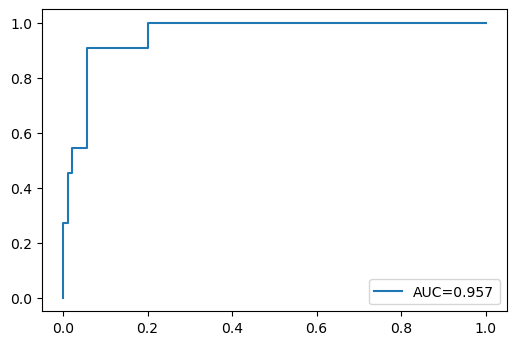

In [35]:
plot_roc(ytest, yTestScore)